# Logistic-Regression-Breast-Cancer

## Import Software Libraries

In [1]:
import os  # Interact with the operating system.
import sys  # Read system parameters.
from io import StringIO  # Read and write strings as files
from urllib.parse import urlparse  # Parse URL and extract path component

import matplotlib  # Create charts.
import matplotlib.pyplot as plt
import numpy as np  # Work with multi-dimensional arrays and matrices.
import pandas as pd  # Manipulate and analyze data frames.
import requests  # Send HTTP requests
import seaborn as sns  # Streamline charting.
import sklearn  # Perform feature engineering and machine learning.
import statsmodels
from scipy.stats import zscore
from sklearn import datasets  # ML datasets
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split

# Summarize software libraries used.
print("Libraries used in this project:")
print("- NumPy {}".format(np.__version__))
print("- pandas {}".format(pd.__version__))
print("- scikit-learn {}".format(sklearn.__version__))
print("- Matplotlib {}".format(matplotlib.__version__))
print("- Seaborn {}".format(sns.__version__))
print("- Python {}\n".format(sys.version))
print("\nSummary of software packages complete.\n")

Libraries used in this project:
- NumPy 1.22.3
- pandas 1.4.1
- scikit-learn 1.2.2
- Matplotlib 3.8.4
- Seaborn 0.11.2
- Python 3.9.20 (main, Oct  3 2024, 02:27:54) 
[Clang 14.0.6 ]


Summary of software packages complete.



# Load the Dataset.

The first step is to load the data and transform the array into a pandas data frame.

In [2]:
# Capture URL
url = "https://raw.githubusercontent.com/tyrantdavis/datasets/refs/heads/main/breast_cancer_data.csv"
request = requests.get(url).text

# Save as data frame and copy
cancer = pd.read_csv(StringIO(request))
df = cancer.copy()

# Parse URL
parsed_url = urlparse(url)
path = parsed_url.path
filename = os.path.basename(path)


print(f"Loaded {len(df)} records from {filename}.")

Loaded 569 records from breast_cancer_data.csv.


## Get Acquainted with the Dataset
Examine the data types and check for any missing entries.

**Examine the first 5 observations**

In [3]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


**Examine the columns, data types, and check for missing values**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

**Spotlights** 

- The dataset comprises 569 rows and 33 columns in total.
- Among these columns, 31 are designated for float values, 1 for integers, and 1 for objects.
- The 'Unnamed: 32' column is devoid of any records, while an 'id' column is present but deemed unnecessary; both will be eliminated eventually. No other missing records are identified.
- The name for **concave points_worst** will be altered to facilitate access to the feature through dot notation.
- The diagnosis feature classes will be encoded and represented as 0 and 1 opposed to **B**(Benign) and **M**(Malignant)

**Verify that each observations is independent**

To determine whether the count of unique IDs matches the sample size, it is essential to verify that there are no duplicate entries for patients.

In [5]:
uniqueids = df.id.nunique()
idcounts = df.id.count()
print(f"All observations independent? {uniqueids == idcounts}\n")

All observations independent? True



**Examine Diagnosis Values**

The subsequent phase involves encoding the diagnosis feature classes and confirming the presence of two distinct classes within the target(**diagnosis**), thereby establishing it as a binary classification.  The dataset should display unique diagnostic values along with their corresponding frequencies.

**Encode 'Benign' as 0, 'Malignant' as 1**

In [6]:
df["diagnosis"] = df["diagnosis"].replace({"M": 1, "B": 0})

In [7]:
diagnosis_class_counts = df["diagnosis"].value_counts()
print("Benign (Class 0):", diagnosis_class_counts[0], "\n")
print("Malignant (Class 1):", diagnosis_class_counts[1], "\n")

Benign (Class 0): 357 

Malignant (Class 1): 212 



**Plot Class Frequencies**

<Axes: title={'center': 'Count (Diagnosis)'}>

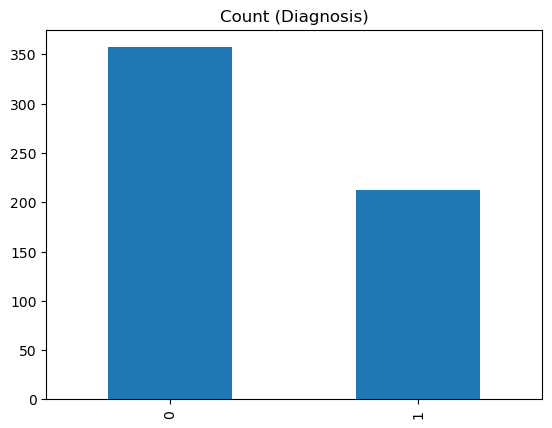

In [8]:
diagnosis_class_counts.plot(kind="bar", title="Count (Diagnosis)", grid=False)

**Examine the Feature Maximum**

It is crucial that, even in cases of significant class imbalance, the smallest class adheres to the established rule of thumb. There should be a limit such that the number of features does not exceed one-tenth of the smallest class size.

In [9]:
maximumfeatures = min(df.diagnosis.value_counts() / 10)
print(f"Maximum features: {maximumfeatures:.0f}")

Maximum features: 21


**Rename Column(s)**

This step renames the concave points_worst. This will allow accessing feature values via dot notation for convenience. 

In [10]:
df = df.rename({"concave points_worst": "concave_points_worst"}, axis=1)
df.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave_points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')

**Drop Unused Columns** 

The next step is to drop the '**id**' and the '**Unnamed: 32**' columns.

In [11]:
dropped = ["id", "Unnamed: 32"]
df.drop(dropped, inplace=True, axis=1)

print(
    f"The columns ''{dropped[0]}'' and ''{dropped[1]}' are dropped from the data frame."
)

The columns ''id'' and ''Unnamed: 32' are dropped from the data frame.


**Examine Outliers**

The next step is to examine a boxplot representing the mean features, identified by a predictors array, to identify and eliminate any apparent outliers. Logistic regression exhibits a notable sensitivity to outliers; therefore, it is essential to eliminate any significantly influential outliers prior to constructing the model. 

Given that the features do not follow a normal distribution it is more insightful to analyze the boxplot of the log-transformed z-scores.

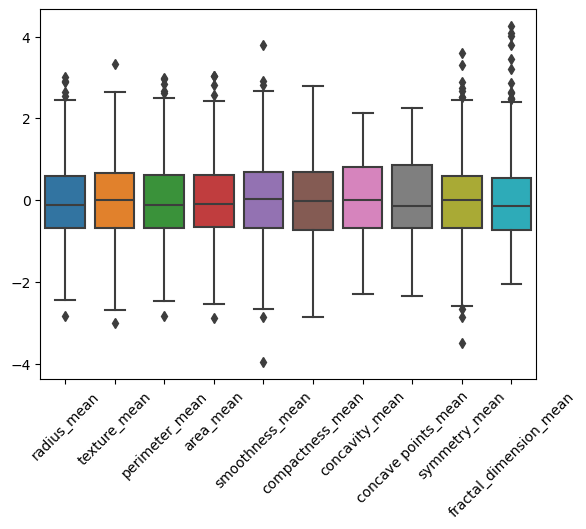

In [12]:
predictors = [
    "radius_mean",
    "texture_mean",
    "perimeter_mean",
    "area_mean",
    "smoothness_mean",
    "compactness_mean",
    "concavity_mean",
    "concave points_mean",
    "symmetry_mean",
    "fractal_dimension_mean",
]

sns.boxplot(data=np.log(df[predictors] + 0.01).apply(zscore))
plt.xticks(rotation=45)
plt.show()
plt.close()

**Spotlights** 

All of the following features have outliers: **fractal_dimension_mean, smoothness_mean, symmetry_mean, texture_mean**

**Remove Extreme Outliers** 

Logistic regressions exhibit a notable sensitivity to extreme outliers, which can significantly skew the results of the analysis. The feature known as fractal_dimension_mean contains numerous extreme outliers that exceed the general distribution of its dataset.

The subsequent phase will involve the elimination of any samples that exceed the 99th percentile and re-plotting the filtered data frame. 

In [13]:
filtered_feature = "fractal_dimension_mean"

high_quantile = df[filtered_feature].quantile(0.99)
filtered_dataframe = df[(df["fractal_dimension_mean"] < high_quantile)]

print(f"Quantile: ({filtered_feature}) dropped from the dataset.\n\n")

Quantile: (fractal_dimension_mean) dropped from the dataset.




**Plot Filtered Data Frame**

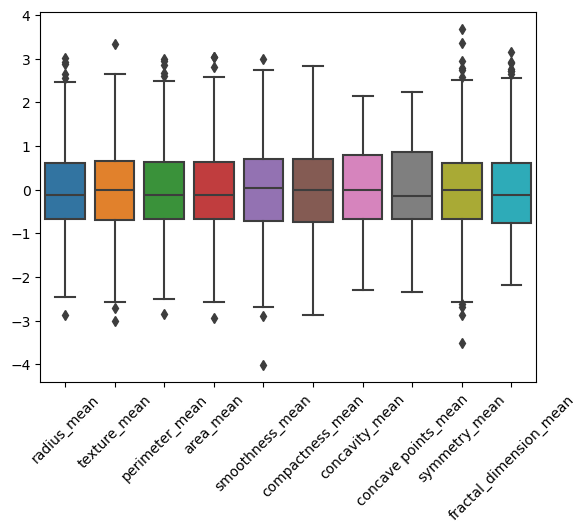

In [14]:
sns.boxplot(data=np.log(filtered_dataframe[predictors] + 0.01).apply(zscore))
plt.xticks(rotation=45)
plt.show()
plt.close()

**Examine the Sigmoidal Curves**

The fundamental premise of logistic regression is that there exists a linear relationship between the features and the logit of the dependent variable. To visually assess this relationship, one can utilize Seaborn's ```regplot``` setting the parameter **logistic** to **True** and selecting our feature of interest as the **x value**. When this condition is satisfied, the resulting fitted model will exhibit a sigmoidal curve. 

The next step is to create another plot using the feature **fractal_dimension_mean**

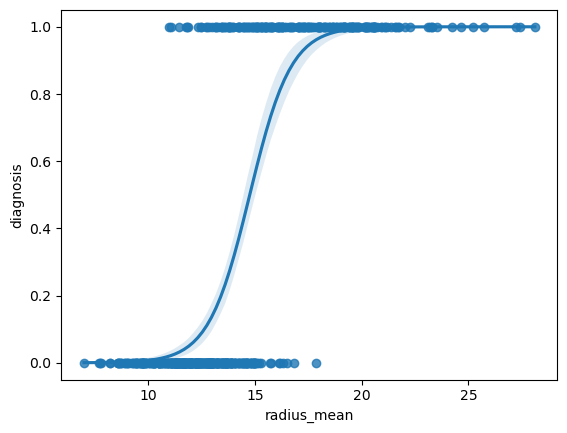

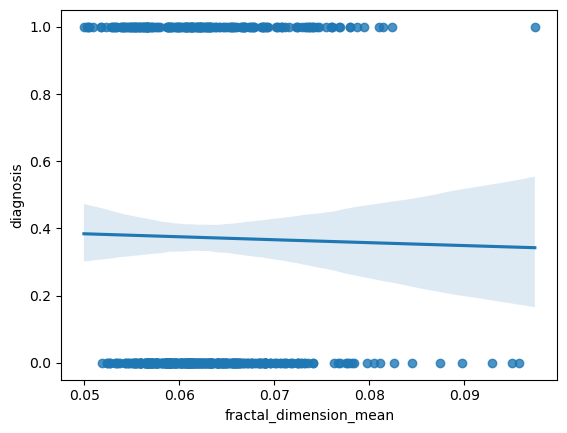

In [17]:
sns.regplot(
    x="radius_mean",
    y="diagnosis",
    data=df,
    logistic=True,
)

plt.show()
plt.close()
sns.regplot(x="fractal_dimension_mean", y="diagnosis", data=df, logistic=True)
plt.show()
plt.close()

**Spotlights** 

When x is set to radius_mean feature the sigmodial curve is evident unlike the fractal_dimension_mean feature.